In [2]:
from skimage.io import imread
from collections import defaultdict
from skimage.transform import resize
import matplotlib.pyplot as plt
from IPython.display import clear_output
import numpy as np
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from matplotlib import rcParams
import random
import os
from tqdm import tqdm

def seed_everything(seed=1):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
rcParams['figure.figsize'] = (15,4)

## Dataset download

1. Скачать датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>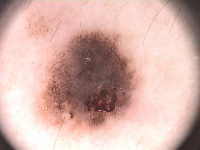</td><td>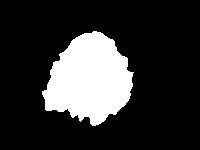</td></tr></table>

2. Разархивирировать .rar файл.
3. Папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.

In [1]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

Для загрузки датасета я предлагаю использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []

root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Меняем их размер на $256\times256 $ пикселей и нормализуем [0,1].

In [4]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [8]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

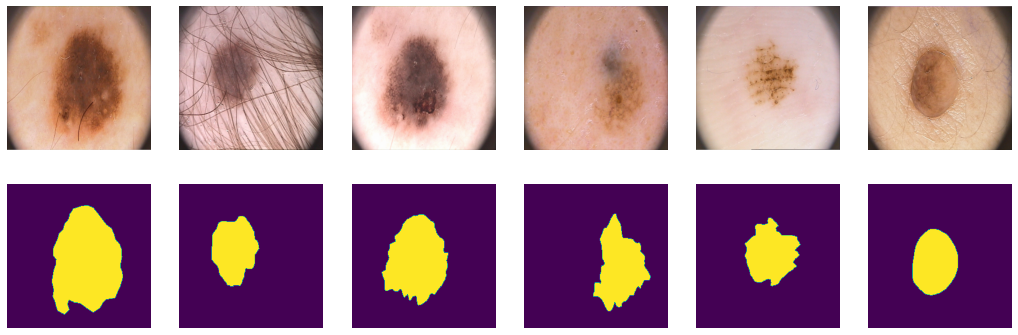

In [7]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для валидации и теста

In [10]:
seed_everything()
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [11]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [12]:
seed_everything()
batch_size_train = 20
batch_size_val_test = 20
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size_train, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size_val_test, shuffle=False)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size_val_test, shuffle=False)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур

-----------------------------------------------------------------------------------------

# SegNet

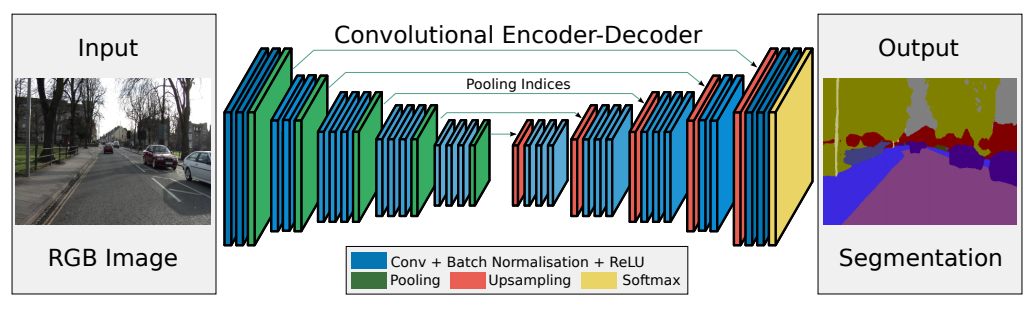

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

In [10]:
class SegNet(nn.Module):
    def __init__(self, input_chanel=3):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(input_chanel, 32, kernel_size=3, padding=1)
        self.enc_bn0 = nn.BatchNorm2d(32)
        self.pool0 = nn.MaxPool2d(2, 2 , return_indices=True)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.enc_bn3 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(2, 2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(256, 256, kernel_size=1, padding=0)
        self.bottleneck_bn = nn.BatchNorm2d(256)
        
        # decoder (upsampling)
#         self.upsample0 = nn.Upsample(scale_factor=2) # 16 -> 32
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dec_bn0 = nn.BatchNorm2d(128)
#         self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv1 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
#         self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
#         self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

    def forward(self, x):
        # encoder
        e0, id0 = self.pool0(F.relu(self.enc_bn0(self.enc_conv0(x))))
        e1, id1 = self.pool1(F.relu(self.enc_bn1(self.enc_conv1(e0))))
        e2, id2 = self.pool2(F.relu(self.enc_bn2(self.enc_conv2(e1))))
        e3, id3 = self.pool3(F.relu(self.enc_bn3(self.enc_conv3(e2))))

        # bottleneck
        b = F.relu(self.bottleneck_bn(self.bottleneck_conv(e3)))
        
        # decoder
        d0 = F.relu(self.dec_bn0(self.dec_conv0(self.upsample0(b, id3))))
        d1 = F.relu(self.dec_bn1(self.dec_conv1(self.upsample1(d0, id2))))
        d2 = F.relu(self.dec_bn2(self.dec_conv2(self.upsample2(d1, id1))))
        d3 = self.dec_conv3(self.upsample3(d2, id0)) # no activation
        return d3

## Метрика
$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

In [9]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = torch.sigmoid(outputs) > 0.5
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2)) 
    union = (outputs | labels).float().sum((1, 2))        
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean().item()  # my line

## Основные функции

In [18]:
class MetricMonitor:
    def __init__(self, float_precision=3):
        self.float_precision = float_precision
        self.reset()

    def reset(self):
        self.metrics = defaultdict(lambda: {"val": 0, "count": 0, "avg": 0})

    def update(self, metric_name, val):
        metric = self.metrics[metric_name]

        metric["val"] += val
        metric["count"] += 1
        metric["avg"] = metric["val"] / metric["count"]

    def __str__(self):
        return " | ".join(
            [
                "{metric_name}: {avg:.{float_precision}f}".format(
                    metric_name=metric_name, avg=metric["avg"], float_precision=self.float_precision
                )
                for (metric_name, metric) in self.metrics.items()
            ]
        )


def train(train_loader, model, criterion, optimizer, epoch, metric, device):
    metric_monitor = MetricMonitor()
    model.train()
    stream = tqdm(train_loader)
    running_loss = 0
    running_score = 0
    for i, (images, target) in enumerate(stream, start=1):
        images = images.to(device, non_blocking=False)
        target = target.to(device, non_blocking=False)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, target)
#         print(f'Losses torch: {bce_torch(output, target)}')
#         print(f'Losses mine: {loss}')
        loss.backward()
        optimizer.step()
        score = metric(output, target)
        metric_monitor.update("Loss", loss.item())
        metric_monitor.update("Score", score)
        # Для графика
        ##########################
        running_loss += loss.item()
        running_score += score
        ###########################
        stream.set_description(
            "Epoch: {epoch}. Train.      {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
        )
    epoch_loss = running_loss/len(train_loader)
    epoch_score = running_score/len(train_loader)
    return epoch_loss, epoch_score


def validate(val_loader, model, criterion, epoch, metric, device):
    metric_monitor = MetricMonitor()
    model.eval()
    stream = tqdm(val_loader)
    running_loss = 0
    running_score = 0
    with torch.no_grad():
        for i, (images, target) in enumerate(stream, start=1):
            images = images.to(device, non_blocking=False)
            target = target.to(device, non_blocking=False)
            output = model(images)
            loss = criterion(output, target)
#             print(f'Losses torch: {bce_torch(output, target)}')
#             print(f'Losses mine: {loss}')
            score = metric(output, target)
            metric_monitor.update("Loss", loss.item())
            metric_monitor.update("Score", score)
            # Для графика
            ##########################
            running_loss += loss.item()
            running_score += score
            ###########################
            stream.set_description(
                "Epoch: {epoch}. Validation. {metric_monitor}".format(epoch=epoch, metric_monitor=metric_monitor)
            )
            
    epoch_loss = running_loss/len(val_loader)
    epoch_score = running_score/len(val_loader)
    return epoch_loss, epoch_score


def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)
        with torch.no_grad():
            Y_pred = model(X_batch)
        scores += metric(Y_pred, Y_label)
    return scores/len(data)


def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
        Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)


def draw_segmentation_each_epoch(val_loader, model):
    X_val, Y_val = next(iter(data_val))
    X_val, Y_val = X_val[:4,], Y_val[:4,]
    # show intermediate results
    model.eval()
    with torch.no_grad():
        Y_hat = model(X_val.to(device)).detach().cpu()
    Y_hat = (torch.sigmoid(Y_hat) > 0.5).byte()
    clear_output(wait=True)
    plt.figure(figsize=(20,8))
    for k in range(4):
        plt.subplot(3, 4, k+1)
        plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
        plt.title('Real')
        plt.axis('off')

        plt.subplot(3, 4, k+5)
        plt.imshow(Y_hat[k, 0], cmap='gray')
        plt.title('Output')
        plt.axis('off')

        plt.subplot(3, 4, k+9)
        plt.imshow(Y_val[k, 0], cmap='gray')
        plt.title('Target')
        plt.axis('off')
    plt.show()
    
    
def draw_graphik(loss_list_train, loss_list_val, acc_list_train, acc_list_val):
    ##############Loss#############
    fig, ax = plt.subplots(2, 1, figsize=(20,15))
    ax[0].plot(loss_list_train, label='Train')
    ax[0].plot(loss_list_val, label='Validation')
    ax[0].set_title('Loss')
    ax[0].legend()
    ############Metric############
    ax[1].plot(acc_list_train, label='Train')
    ax[1].plot(acc_list_val, label='Validation')
    ax[1].set_title('Metric')
    ax[1].legend()
    plt.show()

    
def main_loop(train_dataloader, val_dataloader, test_dataloader, model, criterion, optimizer, metric, epochs, device, draw_graphs=True, draw_seg=True, show_final_metric=True, return_info=False):
    train_loss, train_score = [], []
    val_loss, val_score = [], []
    for epoch in range(1, epochs+1):
        # Обучаем
        epoch_loss, epoch_score = train(train_dataloader, model, criterion, optimizer, epoch, metric, device)
        train_loss.append(epoch_loss)
        train_score.append(epoch_score)

        # Валидируемся
        epoch_loss, epoch_score = validate(val_dataloader, model, criterion, epoch, metric, device)
        val_loss.append(epoch_loss)
        val_score.append(epoch_score)
        
        # Рисуем результат сегментации
        if draw_seg:
            draw_segmentation_each_epoch(val_dataloader, model)
        
    # Рисуем графики
    if draw_graphs:
        draw_graphik(train_loss, val_loss, train_score, val_score)
    
    # Считаем скор на тесте    
    test_score = score_model(model, metric, test_dataloader)
    val_score_final = score_model(model, metric, val_dataloader)
    if show_final_metric:
        print("\t\t\t\tМетрика на тестовом датасете: ", test_score)
        print("\t\t\t\tМетрика на валидационном датасете: ", val_score_final)
    
    if return_info:
        return train_loss, train_score, val_loss, val_score, test_score, val_score_final

-----------------------------------------------------------------------------------------
## BCE loss
$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [8]:
def bce_loss(y_pred, y_real):
    return (torch.maximum(y_pred, torch.tensor(0).to(device)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))).mean()

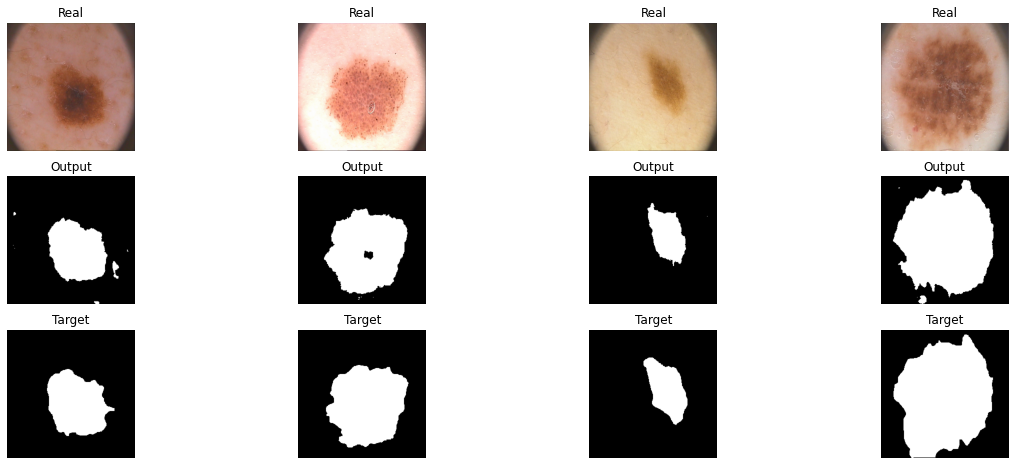

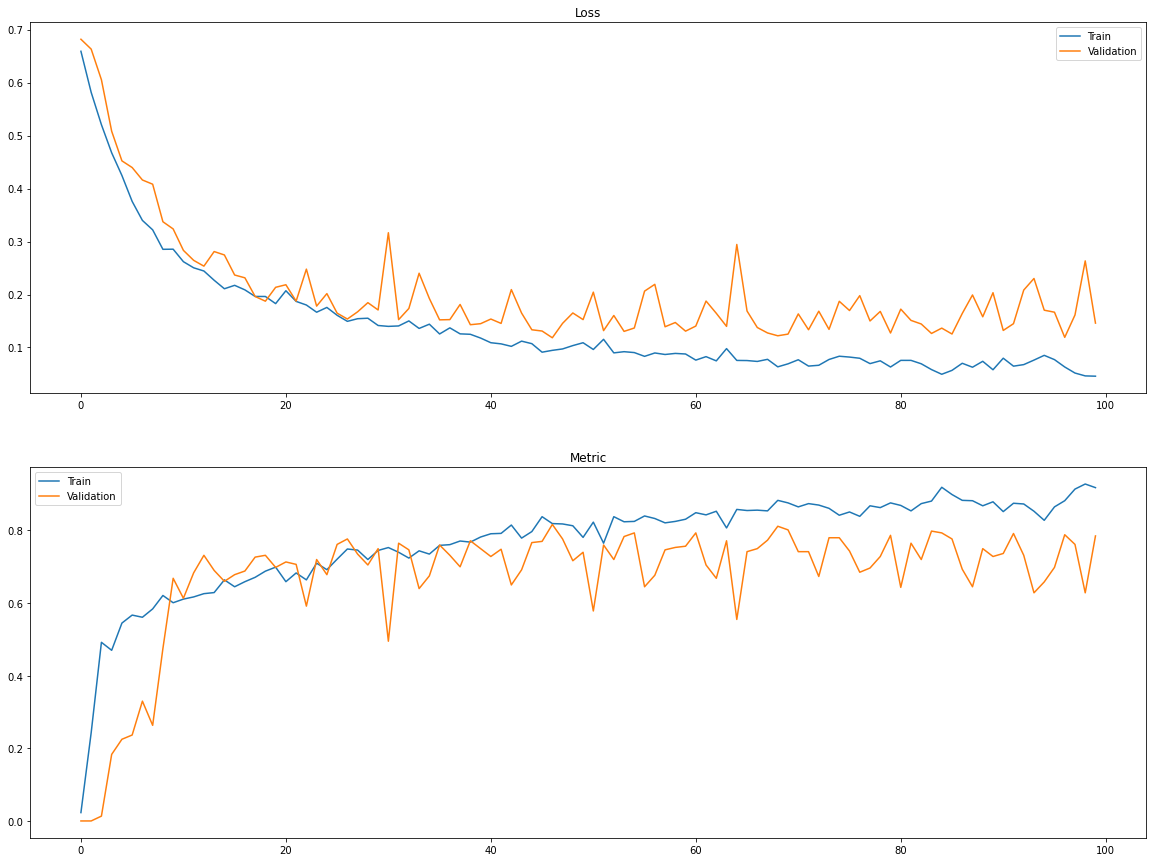

				Метрика на тестовом датасете:  0.7416666944821676
				Метрика на валидационном датасете:  0.7850000460942587


In [19]:
seed_everything()
model = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model.parameters())
main_loop(data_tr, data_val, data_ts, model, bce_loss, optimizer, iou_pytorch, max_epochs, device, draw_graphs=True, draw_seg=True, show_final_metric=True, return_info=False)

del model, optimizer
torch.cuda.empty_cache()

-----------------------------------------------------------------------------------------
## DICE loss

In [19]:
def dice_loss(inputs, targets, eps=1e-8):
    inputs = torch.sigmoid(inputs).view(-1)
    inputs = torch.clamp(inputs, eps, 1.-eps)
    targets = targets.view(-1)
    
    intersection = (inputs * targets).sum()                            
    dice = (2.*intersection + eps)/(inputs.sum() + targets.sum() + eps)  
    return 1 - dice

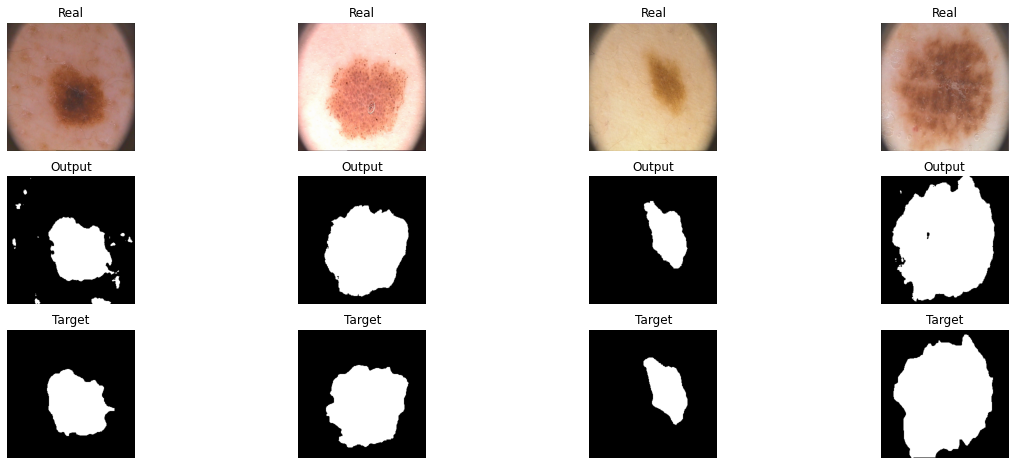

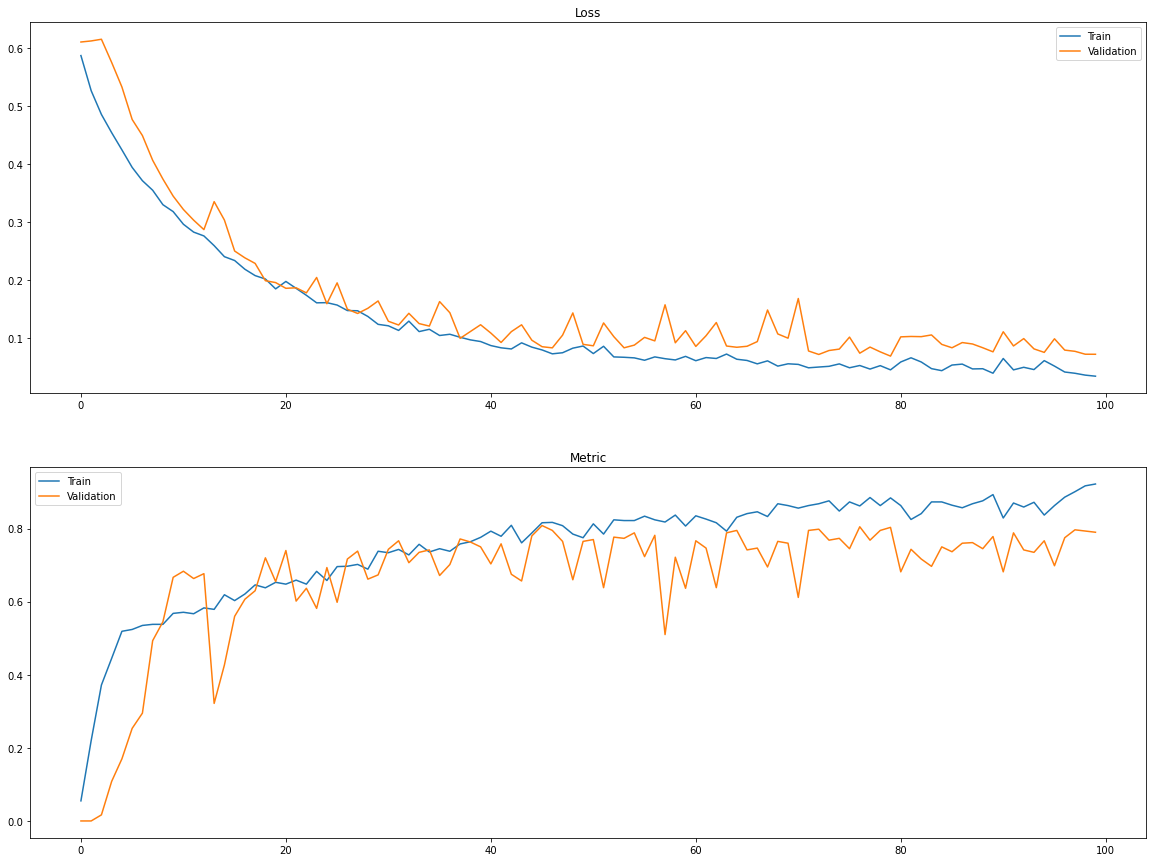

				Метрика на тестовом датасете:  0.7566667199134827
				Метрика на валидационном датасете:  0.7900000214576721


In [21]:
seed_everything()
model_dice = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_dice.parameters())
main_loop(data_tr, data_val, data_ts, model_dice, dice_loss, optimizer, iou_pytorch, max_epochs, device)

del model_dice, optimizer
torch.cuda.empty_cache()

--------------------------------------------------------------------------------
## Focal loss

In [20]:
def focal_loss(inputs, targets, eps = 1e-8, alpha=0.25, gamma = 2.):
    inputs = torch.sigmoid(inputs).view(-1)
    targets = targets.view(-1)
    inputs = torch.clamp(inputs, eps, 1.-eps)
    
    p_t = torch.where(targets==1., inputs, 1-inputs)
    alpha_t = torch.where(targets==1., alpha, 1-alpha)
    
    loss_bce = - torch.log(p_t)
#     weight = alpha_t * torch.pow(1.-p_t, gamma)
    weight = torch.pow(1.-p_t, gamma)
    focal_loss = weight * loss_bce
    return torch.mean(focal_loss)

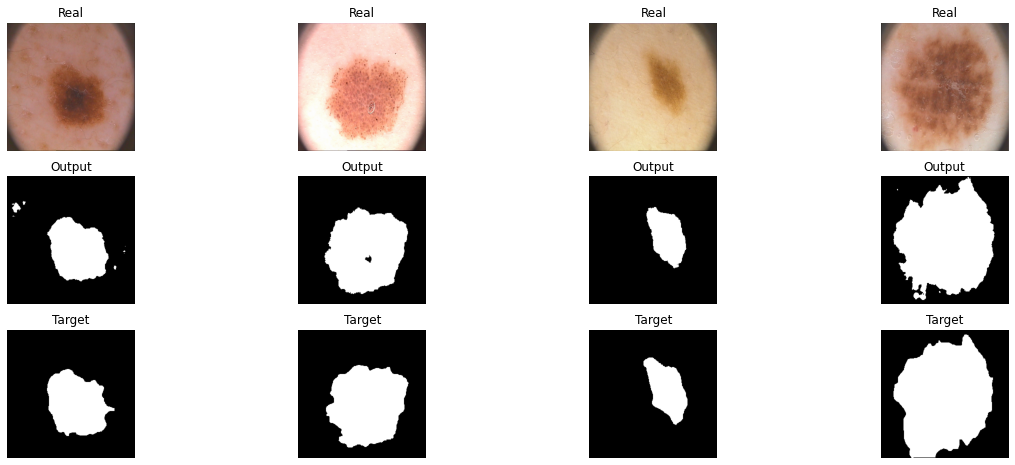

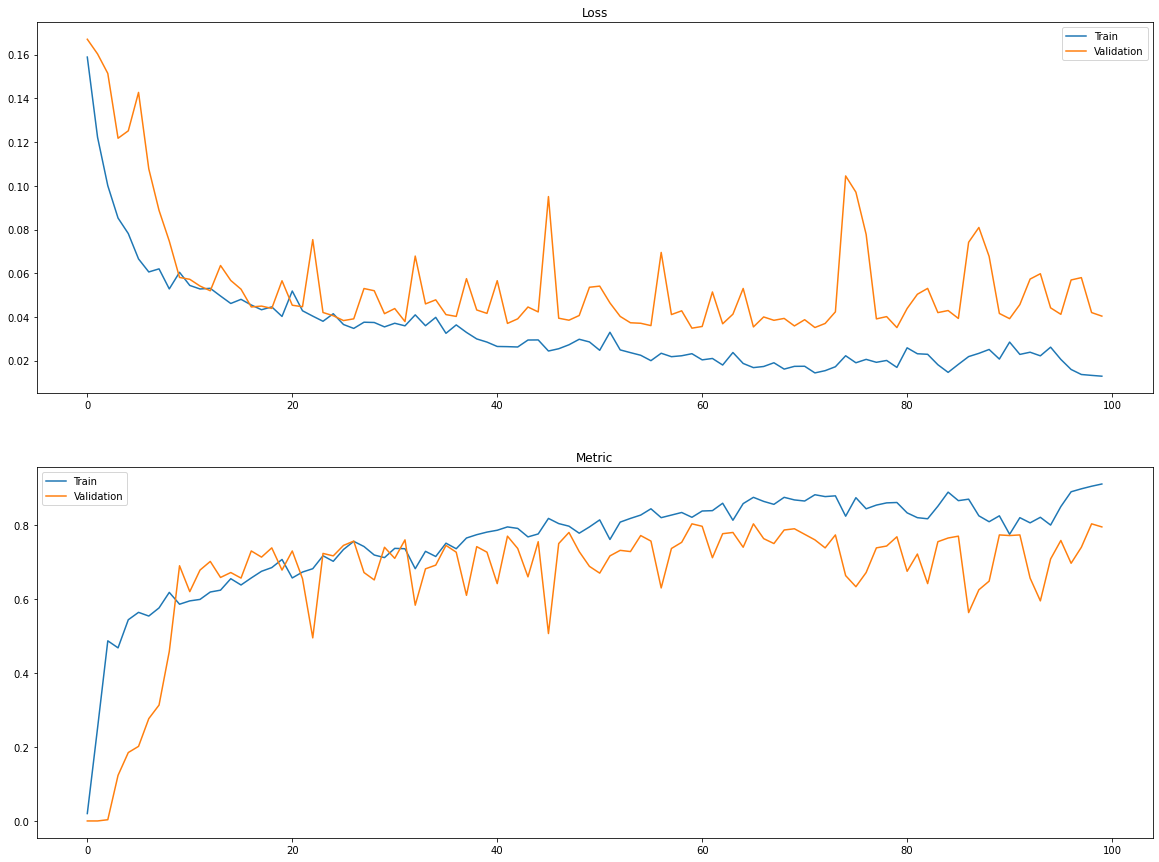

				Метрика на тестовом датасете:  0.75
				Метрика на валидационном датасете:  0.7950000564257304


In [23]:
seed_everything()
model_focal = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_focal.parameters())
main_loop(data_tr, data_val, data_ts, model_focal, focal_loss, optimizer, iou_pytorch, max_epochs, device)

del model_focal, optimizer
torch.cuda.empty_cache()

----------------------------------------------------------------------------------------------

##  BCE with Soft Targets loss

In [21]:
def bce(y_pred, y_real):
    return torch.maximum(y_pred, torch.tensor(0).to(device)) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred)))

def bce_with_soft_targets(preds, targets, label_smooth=0.2):
    confidence = 1 - label_smooth
    eps = label_smooth
    noise_distr = 0.5 + 0*targets # use uniform distrib for noise
    return (confidence * bce(preds, targets) + eps * bce(preds, noise_distr)).mean()

In [45]:
#########Segnet with Focal loss###########
seed_everything()
model_focal = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_focal.parameters())
train_loss_focal, train_score_focal, val_loss_focal, val_score_focal, test_score_focal, val_final_score_focal = main_loop(data_tr, data_val, data_ts, model_focal, focal_loss, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=True, return_info=True)

del model_focal, optimizer
torch.cuda.empty_cache()

In [46]:
#########Segnet with DICE loss###########
seed_everything()
model_dice = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_dice.parameters())
train_loss_dice, train_score_dice, val_loss_dice, val_score_dice, test_score_dice, val_final_score_dice = main_loop(data_tr, data_val, data_ts, model_dice, dice_loss, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=True, return_info=True)

del model_dice, optimizer
torch.cuda.empty_cache()

In [47]:
#########Segnet with BCE loss###########
seed_everything()
model_bce = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_bce.parameters())
train_loss_bce, train_score_bce, val_loss_bce, val_score_bce, test_score_bce, val_final_score_bce = main_loop(data_tr, data_val, data_ts, model_bce, bce_loss, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=True, return_info=True)

del model_bce, optimizer
torch.cuda.empty_cache()

In [48]:
#########Segnet with BCE Soft Targets loss###########
seed_everything()
model_bce_soft_targets = SegNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(model_bce_soft_targets.parameters())
train_loss_bce_soft_targets, train_score_bce_soft_targets, val_loss_bce_soft_targets, val_score_bce_soft_targets, test_score_bce_soft_targets, val_final_score_bce_soft_targets = main_loop(data_tr, data_val, data_ts, model_bce_soft_targets, bce_with_soft_targets, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=True, return_info=True)

del model_bce_soft_targets, optimizer
torch.cuda.empty_cache()

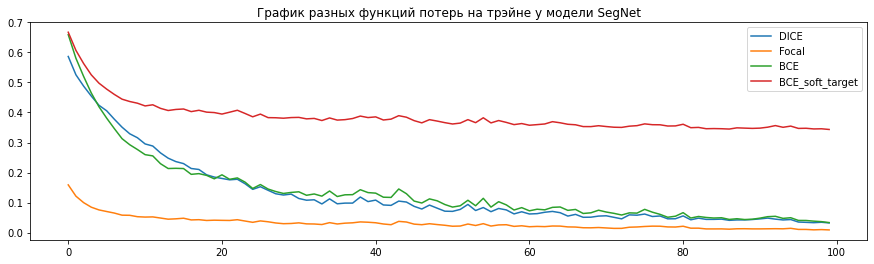

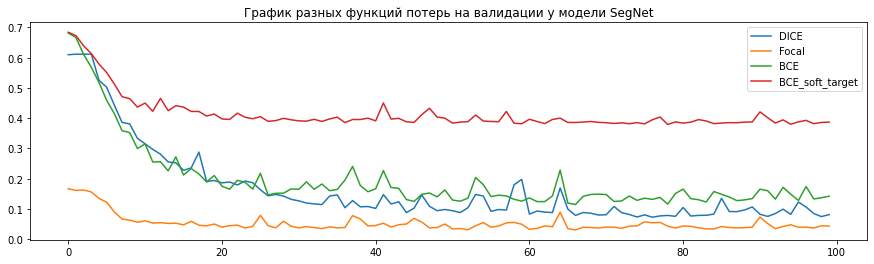

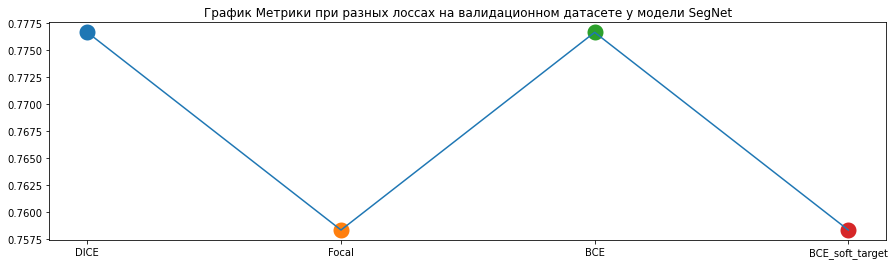

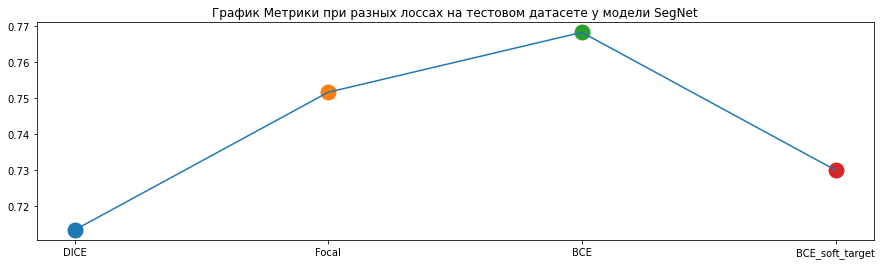

In [33]:
losses = {
    'DICE' : [train_loss_dice, val_loss_dice],
    'Focal': [train_loss_focal, val_loss_focal],
    'BCE': [train_loss_bce, val_loss_bce],
    'BCE_soft_target': [train_loss_bce_soft_targets, val_loss_bce_soft_targets]
}

scores_val = {
    'DICE' : [val_final_score_dice],
    'Focal': [val_final_score_focal],
    'BCE': [val_final_score_bce],
    'BCE_soft_target': [val_final_score_bce_soft_targets]
}

scores_test = {
    'DICE' : [test_score_dice],
    'Focal': [test_score_focal],
    'BCE': [test_score_bce],
    'BCE_soft_target': [test_score_bce_soft_targets]
}

for name_model_loss, name_model_score in zip(losses.keys(), scores_val.keys()):
    plt.plot(losses[name_model_loss][0], label=name_model_loss)
plt.title('График разных функций потерь на трэйне у модели SegNet')
plt.legend()
plt.show()

for name_model_loss, name_model_score in zip(losses.keys(), scores_val.keys()):
    plt.plot(losses[name_model_loss][1], label=name_model_loss)
plt.title('График разных функций потерь на валидации у модели SegNet')
plt.legend()
plt.show()

temp = []
for name_model in scores_val.keys():
    plt.scatter(name_model, scores_val[name_model], alpha=1, linewidths=10)
    temp.append(scores_val[name_model])
plt.plot(temp)
plt.title('График Метрики при разных лоссах на валидационном датасете у модели SegNet')
plt.show()

temp = []
for name_model in scores_test.keys():
    plt.scatter(name_model, scores_test[name_model], alpha=1, linewidths=10)
    temp.append(scores_test[name_model])
plt.plot(temp)
plt.title('График Метрики при разных лоссах на тестовом датасете у модели SegNet')
plt.show()

-----------------------------------------------------------------------------------------

# U-Net

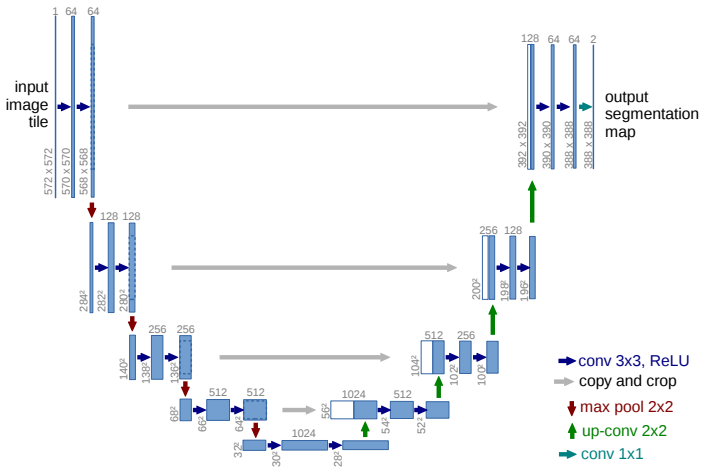

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [22]:
class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(inplace=True))
        self.pool0 =  nn.MaxPool2d(2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True))
        self.pool1 =  nn.MaxPool2d(2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True))
        self.pool2 =  nn.MaxPool2d(2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True))
        self.pool3 =  nn.MaxPool2d(2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(512, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True))
        self.upsample1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True))
        self.upsample2 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(inplace=True))
        self.upsample3 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1))

    def forward(self, x):
        # encoder
        u0 = self.enc_conv0(x)
        e0 = self.pool0(u0)
        
        u1 = self.enc_conv1(e0)
        e1 = self.pool1(u1)
        
        u2 = self.enc_conv2(e1)
        e2 = self.pool2(u2)
        
        u3 = self.enc_conv3(e2)
        e3 = self.pool3(u3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        x0 = torch.cat([self.upsample0(b), u3], dim=1)
        d0 = self.dec_conv0(x0)
        
        x1 = torch.cat([self.upsample1(d0), u2], dim=1)
        d1 = self.dec_conv1(x1)
        
        x2 = torch.cat([self.upsample2(d1), u1], dim=1)
        d2 = self.dec_conv2(x2)
        
        x3 = torch.cat([self.upsample3(d2), u0], dim=1)
        d3 = self.dec_conv3(x3)  # no activation
        
        return d3

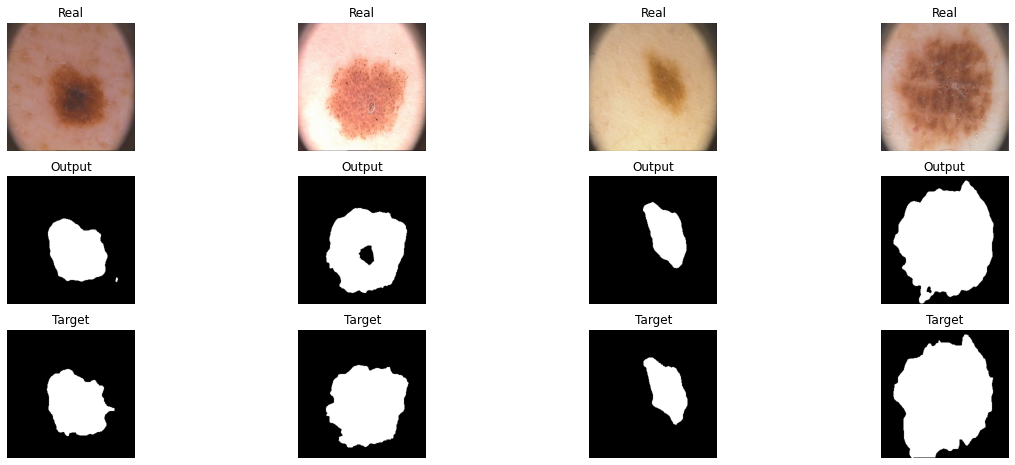

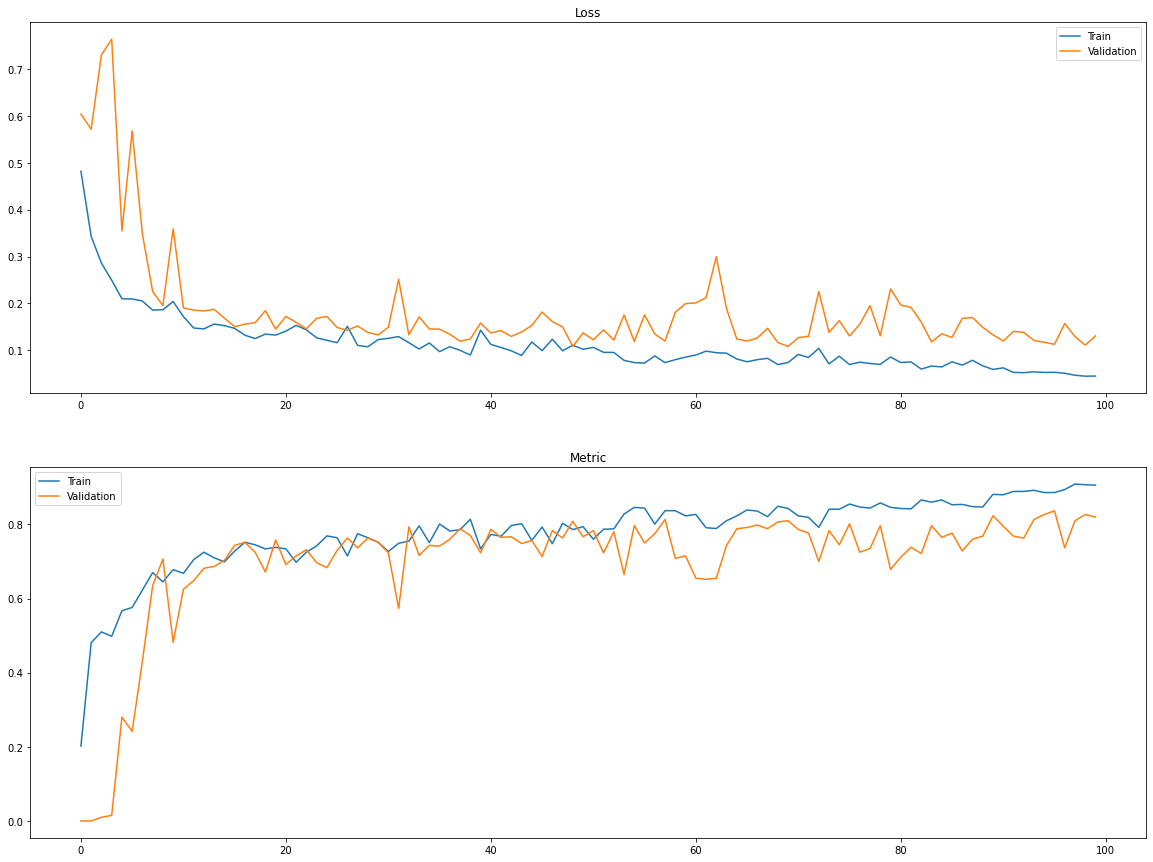

				Метрика на тестовом датасете:  0.7833333611488342
				Метрика на валидационном датасете:  0.8200000325838724


In [22]:
seed_everything()
unet_model = UNet().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(unet_model.parameters())
main_loop(data_tr, data_val, data_ts, unet_model, bce_loss, optimizer, iou_pytorch, max_epochs, device)

del unet_model, optimizer
torch.cuda.empty_cache()

# Unet с другой версией апсэмплинга

In [23]:
class UNet2(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(inplace=True))
        self.pool0 =  nn.Conv2d(32, 32, kernel_size=2, stride=2)  # 256 -> 128
        self.enc_conv1 = nn.Sequential(nn.Conv2d(32, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True))
        self.pool1 =  nn.Conv2d(64, 64, kernel_size=2, stride=2)   # 128 -> 64
        self.enc_conv2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True))
        self.pool2 =  nn.Conv2d(128, 128, kernel_size=2, stride=2)   # 64 -> 32
        self.enc_conv3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True))
        self.pool3 =  nn.Conv2d(256, 256, kernel_size=2, stride=2)   # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(256, 256, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(256),
                                       nn.ReLU(inplace=True))

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2) # 16 -> 32
        self.dec_conv0 = nn.Sequential(nn.Conv2d(512, 128, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(128),
                                       nn.ReLU(inplace=True))
        self.upsample1 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(nn.Conv2d(256, 64, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(64),
                                       nn.ReLU(inplace=True))
        self.upsample2 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(nn.Conv2d(128, 32, kernel_size=3, padding=1),
                                       nn.BatchNorm2d(32),
                                       nn.ReLU(inplace=True))
        self.upsample3 = nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(nn.Conv2d(64, 1, kernel_size=3, padding=1))

    def forward(self, x):
        # encoder
        u0 = self.enc_conv0(x)
        e0 = self.pool0(u0)
        
        u1 = self.enc_conv1(e0)
        e1 = self.pool1(u1)
        
        u2 = self.enc_conv2(e1)
        e2 = self.pool2(u2)
        
        u3 = self.enc_conv3(e2)
        e3 = self.pool3(u3)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        x0 = torch.cat([self.upsample0(b), u3], dim=1)
        d0 = self.dec_conv0(x0)
        
        x1 = torch.cat([self.upsample1(d0), u2], dim=1)
        d1 = self.dec_conv1(x1)
        
        x2 = torch.cat([self.upsample2(d1), u1], dim=1)
        d2 = self.dec_conv2(x2)
        
        x3 = torch.cat([self.upsample3(d2), u0], dim=1)
        d3 = self.dec_conv3(x3)  # no activation
        
        return d3

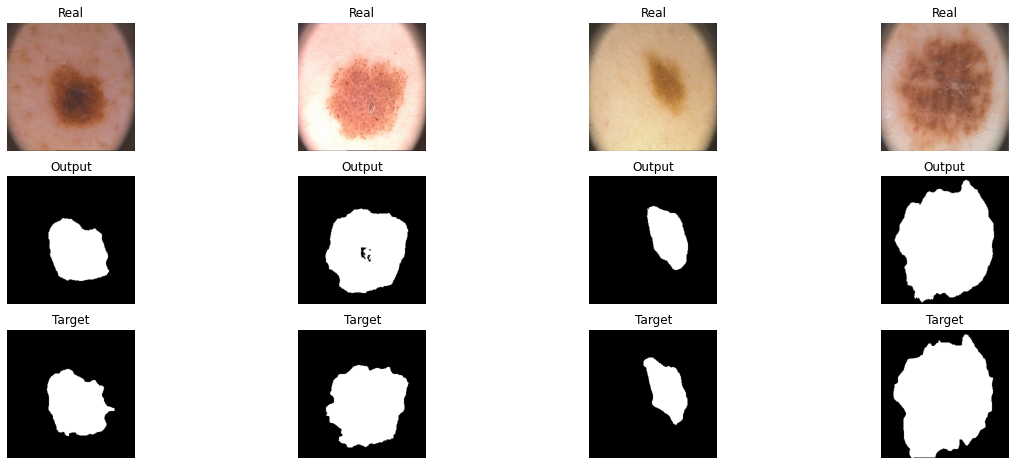

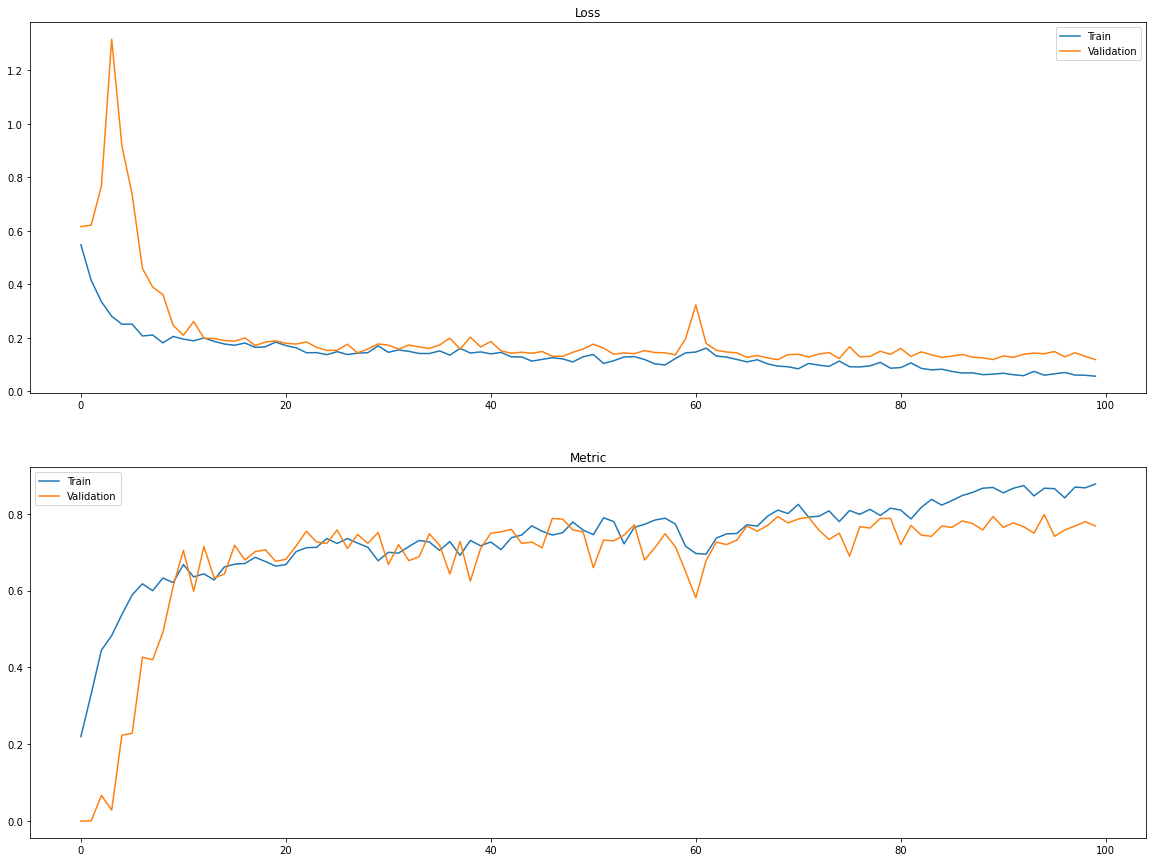

				Метрика на тестовом датасете:  0.8033333818117777
				Метрика на валидационном датасете:  0.768333375453949


In [23]:
seed_everything()
unet_model2 = UNet2().to(device)
max_epochs = 100
optimizer = torch.optim.Adam(unet_model2.parameters())
main_loop(data_tr, data_val, data_ts, unet_model2, bce_loss, optimizer, iou_pytorch, max_epochs, device)

##############Очищаем память###############
del unet_model2, optimizer
torch.cuda.empty_cache()

# Выводы

## 1. Какая из функций потерь лучше для модели SegNet ?
Под лучшей функцией потерь будем понимать следующее - при каком из лоссов удалось достичь наибольшего iou-скора на тесте.

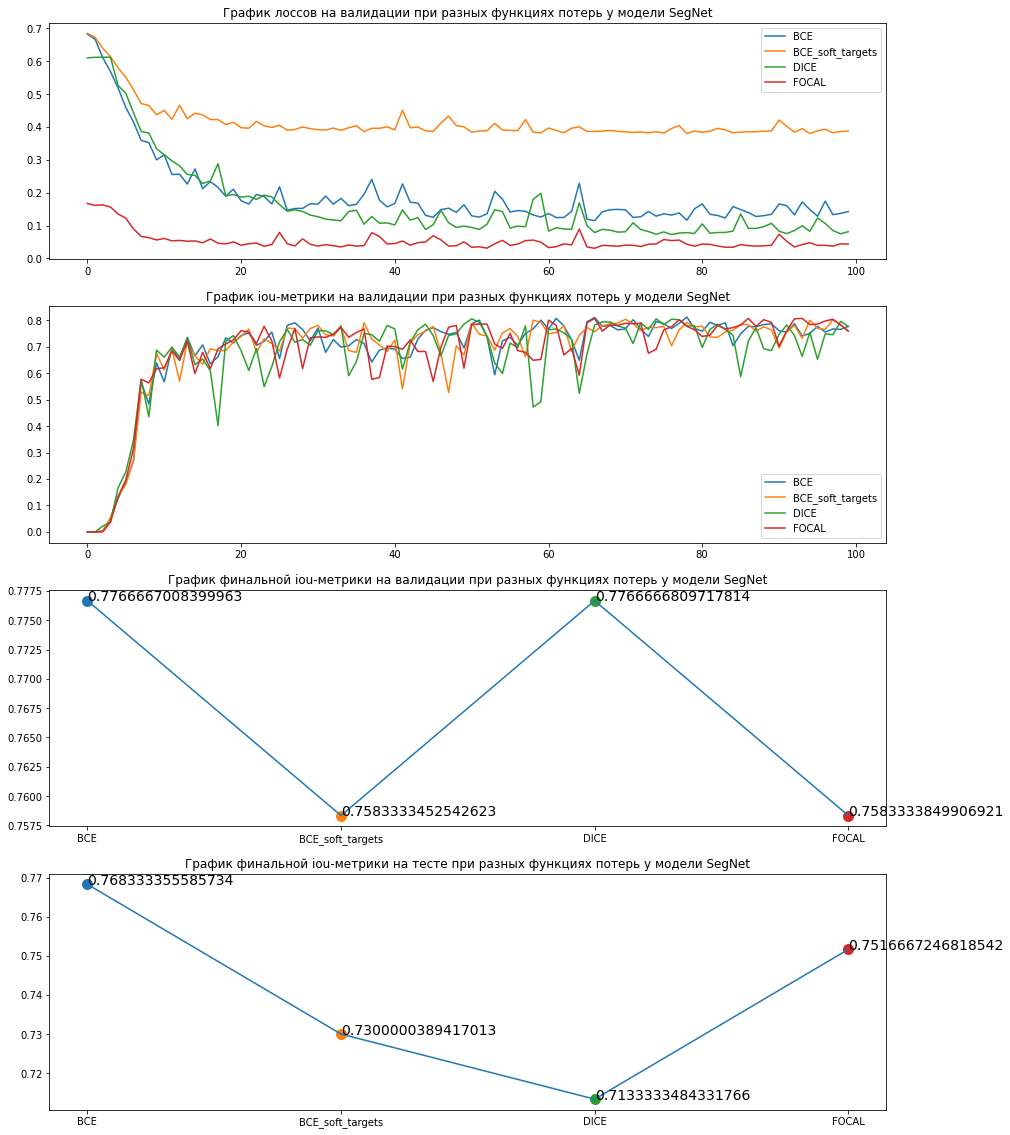

In [40]:
def draw_graph(losses_val, scores_val_epochs, scores_val, scores_test):
    fig, ax = plt.subplots(4, 1, figsize=(15,20))
    ###############################
    for loss_name in losses_val.keys():
        ax[0].plot(losses_val[loss_name], label=loss_name)
    ax[0].set_title('График лоссов на валидации при разных функциях потерь у модели SegNet')
    ax[0].legend()
    ###############################
    for loss_name in losses_val.keys():
        ax[1].plot(scores_val_epochs[loss_name], label=loss_name)
    ax[1].set_title('График iou-метрики на валидации при разных функциях потерь у модели SegNet')
    ax[1].legend()
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[2].scatter(loss_name, scores_val[loss_name], linewidths=5)
        ax[2].annotate(scores_val[loss_name], (loss_name, scores_val[loss_name]), fontsize=14)
        temp.append(scores_val[loss_name])
    ax[2].plot(temp)
    ax[2].set_title('График финальной iou-метрики на валидации при разных функциях потерь у модели SegNet')
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[3].scatter(loss_name, scores_test[loss_name], linewidths=5)
        ax[3].annotate(scores_test[loss_name], (loss_name, scores_test[loss_name]), fontsize=14)
        temp.append(scores_test[loss_name])
    ax[3].plot(temp)
    ax[3].set_title('График финальной iou-метрики на тесте при разных функциях потерь у модели SegNet')
    
losses_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val_epochs = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_test = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
loss_functions = [bce_loss, bce_with_soft_targets, dice_loss, focal_loss]

for loss_name, loss_func in zip(losses_val.keys(), loss_functions):
    seed_everything()
    model = SegNet().to(device)
    max_epochs = 100
    optimizer = torch.optim.Adam(model.parameters())
    train_loss, train_score, val_loss, val_score, test_score, val_score_final = main_loop(data_tr, data_val, data_ts, model, loss_func, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=False, return_info=True)
    losses_val[loss_name] = val_loss
    scores_val_epochs[loss_name] = val_score
    scores_val[loss_name] = val_score_final
    scores_test[loss_name] = test_score
    del model, optimizer
    torch.cuda.empty_cache()
    clear_output(wait=False)
    
draw_graph(losses_val, scores_val_epochs, scores_val, scores_test)

###### Вывод: для модели SegNet при прочих равных лучшей из лосс функций по метрике-iou на тесте является - BCE. 

## 2. Какая из функций потерь лучше для модели Unet ?
Условия эксперимента идентичны предыдущему.

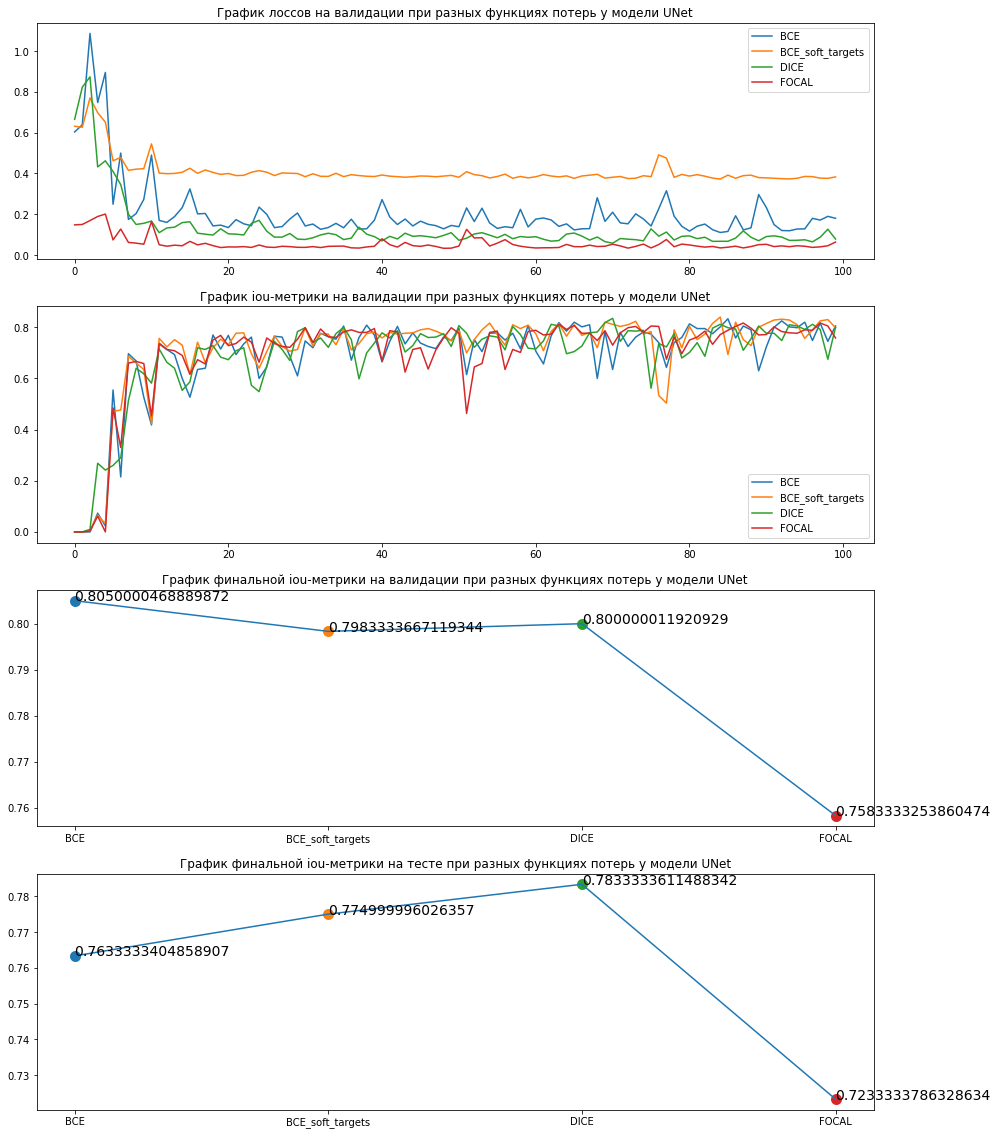

In [24]:
def draw_graph(losses_val, scores_val_epochs, scores_val, scores_test):
    fig, ax = plt.subplots(4, 1, figsize=(15,20))
    ###############################
    for loss_name in losses_val.keys():
        ax[0].plot(losses_val[loss_name], label=loss_name)
    ax[0].set_title('График лоссов на валидации при разных функциях потерь у модели UNet')
    ax[0].legend()
    ###############################
    for loss_name in losses_val.keys():
        ax[1].plot(scores_val_epochs[loss_name], label=loss_name)
    ax[1].set_title('График iou-метрики на валидации при разных функциях потерь у модели UNet')
    ax[1].legend()
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[2].scatter(loss_name, scores_val[loss_name], linewidths=5)
        ax[2].annotate(scores_val[loss_name], (loss_name, scores_val[loss_name]), fontsize=14)
        temp.append(scores_val[loss_name])
    ax[2].plot(temp)
    ax[2].set_title('График финальной iou-метрики на валидации при разных функциях потерь у модели UNet')
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[3].scatter(loss_name, scores_test[loss_name], linewidths=5)
        ax[3].annotate(scores_test[loss_name], (loss_name, scores_test[loss_name]), fontsize=14)
        temp.append(scores_test[loss_name])
    ax[3].plot(temp)
    ax[3].set_title('График финальной iou-метрики на тесте при разных функциях потерь у модели UNet')
    
losses_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val_epochs = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_test = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
loss_functions = [bce_loss, bce_with_soft_targets, dice_loss, focal_loss]

for loss_name, loss_func in zip(losses_val.keys(), loss_functions):
    seed_everything()
    model = UNet().to(device)
    max_epochs = 100
    optimizer = torch.optim.Adam(model.parameters())
    train_loss, train_score, val_loss, val_score, test_score, val_score_final = main_loop(data_tr, data_val, data_ts, model, loss_func, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=False, return_info=True)
    losses_val[loss_name] = val_loss
    scores_val_epochs[loss_name] = val_score
    scores_val[loss_name] = val_score_final
    scores_test[loss_name] = test_score
    del model, optimizer
    torch.cuda.empty_cache()
    clear_output(wait=False)
    
draw_graph(losses_val, scores_val_epochs, scores_val, scores_test)

###### Вывод: для модели UNet при прочих равных лучшей из лосс функций по метрике-iou на тесте является - DICE. 

## 3. Какая из функций потерь лучше для модели Unet2 ?
Условия эксперимента идентичны предыдущему.

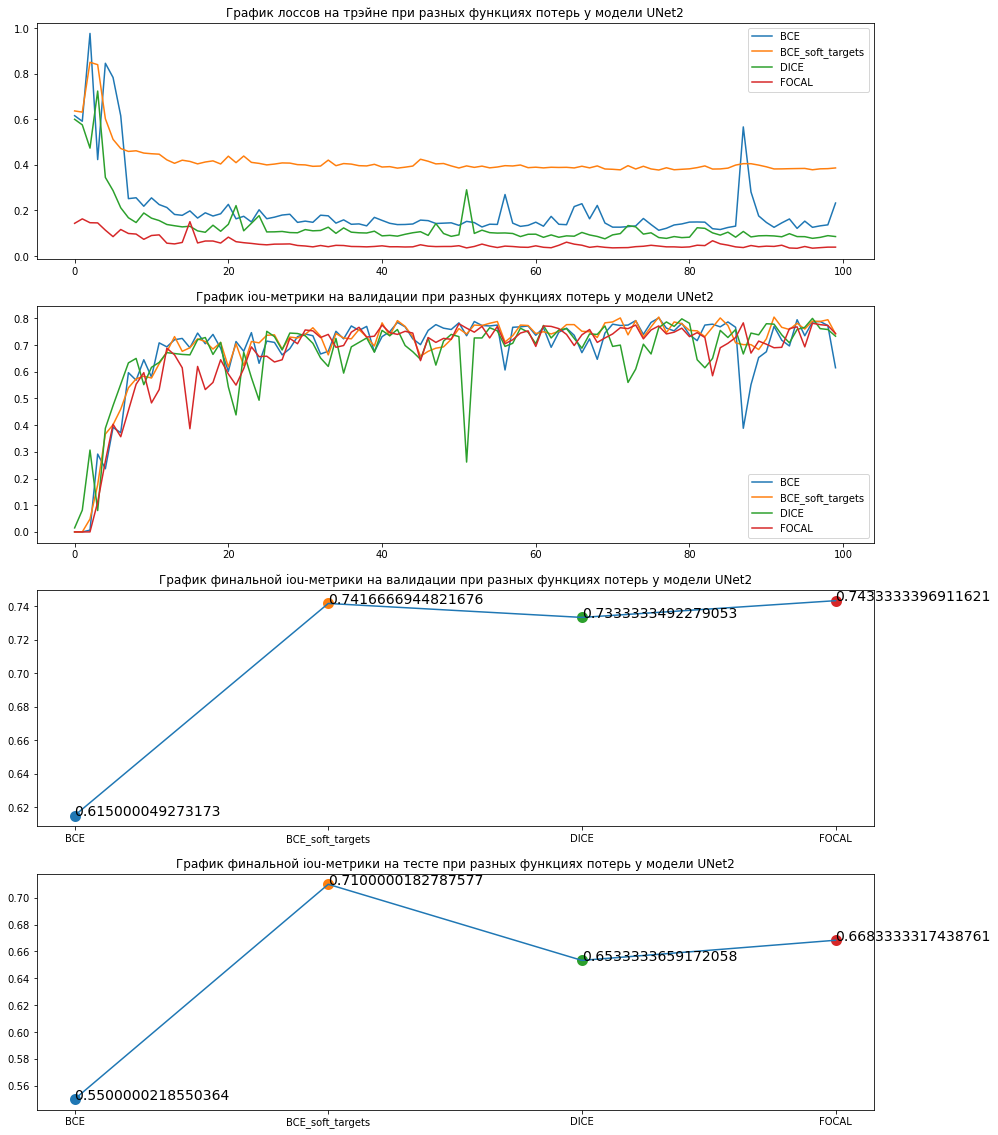

In [25]:
def draw_graph(losses_val, scores_val_epochs, scores_val, scores_test):
    fig, ax = plt.subplots(4, 1, figsize=(15,20))
    ###############################
    for loss_name in losses_val.keys():
        ax[0].plot(losses_val[loss_name], label=loss_name)
    ax[0].set_title('График лоссов на трэйне при разных функциях потерь у модели UNet2')
    ax[0].legend()
    ###############################
    for loss_name in losses_val.keys():
        ax[1].plot(scores_val_epochs[loss_name], label=loss_name)
    ax[1].set_title('График iou-метрики на валидации при разных функциях потерь у модели UNet2')
    ax[1].legend()
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[2].scatter(loss_name, scores_val[loss_name], linewidths=5)
        ax[2].annotate(scores_val[loss_name], (loss_name, scores_val[loss_name]), fontsize=14)
        temp.append(scores_val[loss_name])
    ax[2].plot(temp)
    ax[2].set_title('График финальной iou-метрики на валидации при разных функциях потерь у модели UNet2')
    ###############################
    temp = []
    for loss_name in losses_val.keys():
        ax[3].scatter(loss_name, scores_test[loss_name], linewidths=5)
        ax[3].annotate(scores_test[loss_name], (loss_name, scores_test[loss_name]), fontsize=14)
        temp.append(scores_test[loss_name])
    ax[3].plot(temp)
    ax[3].set_title('График финальной iou-метрики на тесте при разных функциях потерь у модели UNet2')
    
losses_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val_epochs = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_val = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
scores_test = {'BCE': [], 'BCE_soft_targets': [], 'DICE': [], 'FOCAL': []}
loss_functions = [bce_loss, bce_with_soft_targets, dice_loss, focal_loss]

for loss_name, loss_func in zip(losses_val.keys(), loss_functions):
    seed_everything()
    model = UNet2().to(device)
    max_epochs = 100
    optimizer = torch.optim.Adam(model.parameters())
    train_loss, train_score, val_loss, val_score, test_score, val_score_final = main_loop(data_tr, data_val, data_ts, model, loss_func, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=False, return_info=True)
    losses_val[loss_name] = val_loss
    scores_val_epochs[loss_name] = val_score
    scores_val[loss_name] = val_score_final
    scores_test[loss_name] = test_score
    del model, optimizer
    torch.cuda.empty_cache()
    clear_output(wait=False)
    
draw_graph(losses_val, scores_val_epochs, scores_val, scores_test)

###### Вывод: для модели UNet2 при прочих равных лучшей из лосс функций по метрике-iou на тесте является - BCE soft targets . 

## 4. Выбор лучшей модели среди UNet, UNet2, SegNet

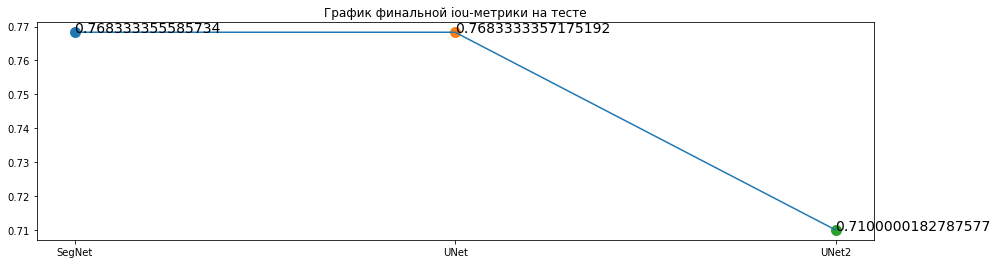

In [44]:
def draw_graph(scores_test):
    ###############################
    temp = []
    for loss_name in scores_test.keys():
        plt.scatter(loss_name, scores_test[loss_name], linewidths=5)
        plt.annotate(scores_test[loss_name], (loss_name, scores_test[loss_name]), fontsize=14)
        temp.append(scores_test[loss_name])
    plt.plot(temp)
    plt.title('График финальной iou-метрики на тесте')
    
models_with_loss = [(SegNet, bce_loss), (UNet, bce_loss), (UNet2, bce_with_soft_targets)]

model_name = {'SegNet': [], 'UNet': [], 'UNet2': []}

for (model_my, loss_func), name in zip(models_with_loss, model_name.keys()):
    seed_everything()
    model = model_my().to(device)
    max_epochs = 100
    optimizer = torch.optim.Adam(model.parameters())
    train_loss, train_score, val_loss, val_score, test_score, val_score_final = main_loop(data_tr, data_val, data_ts, model, loss_func, optimizer, iou_pytorch, max_epochs, device, draw_graphs=False, draw_seg=False, show_final_metric=False, return_info=True)
    model_name[name] = test_score
    del model, optimizer
    torch.cuda.empty_cache()
    clear_output(wait=False)

draw_graph(model_name)

###### Вывод: При прочих равных лучшей моделью по метрике-iou на тестовом датасете является -  SegNet. 